In [ ]:
# Importing the dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from google.colab import files
from torchsummary import summary

# Importing libraries
import csv
import ntpath
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import random
import imgaug.augmenters as iaa

In [ ]:
# Cloning the repository containing the dataset
!git clone https://github.com/NavoditC/End-to-End-Learning.git

fatal: destination path 'End-to-End-Learning' already exists and is not an empty directory.


In [ ]:
# Read the data in a dataframe
path = 'End-to-End-Learning/data/driving_log.csv'
column_names = ['center_image_path','left_image_path','right_image_path','steering angle','throttle','brake','speed']
df = pd.read_csv(path,names=column_names)

In [ ]:
# Extract the relevant path to be used for the images in Google Colab
def split_path(path):
  head,leaf = ntpath.split(path)
  return leaf

df['center_image_path'] = df['center_image_path'].apply(split_path)
df['left_image_path'] = df['left_image_path'].apply(split_path)
df['right_image_path'] = df['right_image_path'].apply(split_path)

df.head()

,center_image_path,left_image_path,right_image_path,steering angle,throttle,brake,speed
0,center_2022_02_27_19_27_14_164.jpg,left_2022_02_27_19_27_14_164.jpg,right_2022_02_27_19_27_14_164.jpg,0.0,0.0,0.0,0.000156
1,center_2022_02_27_19_27_14_265.jpg,left_2022_02_27_19_27_14_265.jpg,right_2022_02_27_19_27_14_265.jpg,0.0,0.0,0.0,0.000156
2,center_2022_02_27_19_27_14_366.jpg,left_2022_02_27_19_27_14_366.jpg,right_2022_02_27_19_27_14_366.jpg,0.0,0.0,0.0,0.000156
3,center_2022_02_27_19_27_14_470.jpg,left_2022_02_27_19_27_14_470.jpg,right_2022_02_27_19_27_14_470.jpg,0.0,0.0,0.0,0.000155
4,center_2022_02_27_19_27_14_570.jpg,left_2022_02_27_19_27_14_570.jpg,right_2022_02_27_19_27_14_570.jpg,0.0,0.0,0.0,0.000156


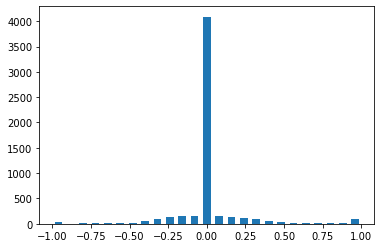

In [ ]:
# Visualize the distribution of the steering angle
steering_angle = df['steering angle']
total_bins = 25
histogram, bins = np.histogram(steering_angle, total_bins)
bins1 = (bins[1:]+bins[:-1])*0.5
plt.bar(bins1, histogram, width = 0.05)
plt.show()

In [ ]:
steering_count = 300
delete_list = []
for i in range(len(bins)-1):
  bin_list = []
  for j in range(len(steering_angle)):
    if steering_angle[j]>=bins[i] and steering_angle[j]<bins[i+1]:
      bin_list.append(j)
  random.shuffle(bin_list)
  if len(bin_list) > steering_count:
    bin_list = bin_list[steering_count:]
    delete_list.extend(bin_list)

In [ ]:
df.drop(df.index[delete_list], inplace=True)

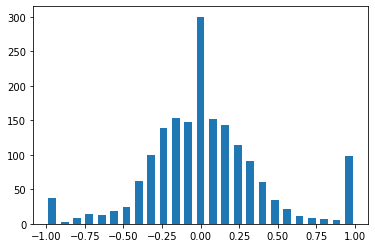

In [ ]:
steering_angle = df['steering angle']
total_bins = 25
histogram, bins = np.histogram(steering_angle, total_bins)
bins1 = (bins[1:]+bins[:-1])*0.5
plt.bar(bins1, histogram, width = 0.05)
plt.show()

In [ ]:
os.makedirs('End-to-End-Learning/data', exist_ok=True)  
df.to_csv('End-to-End-Learning/data/drive.csv',index=False)

In [ ]:
# Reading the csv file which containing the image paths and the steering angle, throttle, brake and speed to make the vehicle perform better on turns
dataset1 = []
center_images = []
left_images = []
right_images = []
center_steering = []
left_steering = []
right_steering = []
with open('End-to-End-Learning/data/drive.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    next(csv_reader, None) # To skip the first line which contains the column names of the dataframe
    for line in csv_reader:
        center_images.append(line[0])
        center_steering.append(float(line[3]))
        left_images.append(line[1])
        left_steering.append(float(line[3])+0.15)
        right_images.append(line[2])
        right_steering.append(float(line[3])-0.15)

In [ ]:
images_center = []
images_left = []
images_right = []
steering_center = []
steering_left = []
steering_right = []

for i in range(0,len(center_images)-3,3):
  image1 = center_images[i]
  image2 = center_images[i+1]
  image3 = center_images[i+2]
  images_center.append([image1,image2,image3])
  steering_center.append(center_steering[i+3])

for i in range(0,len(left_images)-3,3):
  image1 = left_images[i]
  image2 = left_images[i+1]
  image3 = left_images[i+2]
  images_left.append([image1,image2,image3])
  steering_left.append(left_steering[i+3])

for i in range(0,len(right_images)-3,3):
  image1 = right_images[i]
  image2 = right_images[i+1]
  image3 = right_images[i+2]
  images_right.append([image1,image2,image3])
  steering_right.append(right_steering[i+3])

In [ ]:
# Function to perform pre-processing operations in order to achieve data augmentation
def augment(filenames, steering_angle, isTraining):
  filepath1 = 'End-to-End-Learning/data/IMG/' + filenames[0].split('/')[-1]
  filepath2 = 'End-to-End-Learning/data/IMG/' + filenames[1].split('/')[-1]
  filepath3 = 'End-to-End-Learning/data/IMG/' + filenames[2].split('/')[-1]

  current_image1 = cv.imread(filepath1)
  current_image2 = cv.imread(filepath2)
  current_image3 = cv.imread(filepath3)
  if isTraining == True:
    # Flip the image with a 50% prrobability to augment the dataset
    if np.random.rand() < 0.5:
      current_image1 = cv.flip(current_image1, 1)
      current_image2 = cv.flip(current_image2, 1)
      current_image3 = cv.flip(current_image3, 1)
      steering_angle = steering_angle * -1.0  

    # Adjust the brightness of the image to make the model adjust to different times of the day
    if np.random.rand() < 0.5:
      current_image1_hsv = cv.cvtColor(current_image1,cv.COLOR_BGR2HSV)
      current_image2_hsv = cv.cvtColor(current_image2,cv.COLOR_BGR2HSV)
      current_image3_hsv = cv.cvtColor(current_image3,cv.COLOR_BGR2HSV)
      num = np.random.rand()
      adjustment = 0.5 + num*0.5
      current_image1_hsv[:,:,2] = current_image1_hsv[:,:,2]*adjustment
      current_image1 = cv.cvtColor(current_image1_hsv,cv.COLOR_HSV2BGR)
      current_image2_hsv[:,:,2] = current_image2_hsv[:,:,2]*adjustment
      current_image2 = cv.cvtColor(current_image2_hsv,cv.COLOR_HSV2BGR)
      current_image3_hsv[:,:,2] = current_image3_hsv[:,:,2]*adjustment
      current_image3 = cv.cvtColor(current_image3_hsv,cv.COLOR_HSV2BGR)

    # Zoom into the image within a tolerance of 20%
    if np.random.rand() < 0.5:
      zoom = iaa.Affine(scale=(1, 1.2))
      current_image1 = zoom.augment_image(current_image1)
      current_image2 = zoom.augment_image(current_image2)
      current_image3 = zoom.augment_image(current_image3)

  # Crop the image to extract only the road and apply Gaussian blurring to remove noise present in the image
  current_image1 = current_image1[65:135, :, :]
  current_image1 = cv.GaussianBlur(current_image1,  (3, 3), 0)
  current_image2 = current_image2[65:135, :, :]
  current_image2 = cv.GaussianBlur(current_image2,  (3, 3), 0)
  current_image3 = current_image3[65:135, :, :]
  current_image3 = cv.GaussianBlur(current_image3,  (3, 3), 0)
  return [current_image1, current_image2, current_image3], steering_angle

class MyDataset(Dataset):

    def __init__(self, images_center, steering_center, images_left, steering_left, images_right, steering_right, transform=None, isTraining=True):
        self.images_center = images_center
        self.steering_center = steering_center
        self.images_left = images_left
        self.steering_left = steering_left
        self.images_right = images_right
        self.steering_right = steering_right
        self.transform = transform
        self.isTraining = isTraining

    def __getitem__(self, index):
        center_images = self.images_center[index]
        steering_angle_center = self.steering_center[index]
        left_images = self.images_left[index]
        steering_angle_left = self.steering_left[index]
        right_images = self.images_right[index]
        steering_angle_right = self.steering_right[index]


        # Augment the images taken from the center camera and perform image transformations
        center_image, steering_angle_center = augment(center_images, steering_angle_center, self.isTraining)
        center_image = [self.transform(center_image[0]),self.transform(center_image[1]),self.transform(center_image[2])]
        # Augment the images taken from the left camera and perform image transformations
        left_image, steering_angle_left = augment(left_images, steering_angle_left, self.isTraining)
        left_image = [self.transform(left_image[0]),self.transform(left_image[1]),self.transform(left_image[2])]
        # Augment the images taken from the right camera and perform image transformations
        right_image, steering_angle_right = augment(right_images, steering_angle_right, self.isTraining)
        right_image = [self.transform(right_image[0]),self.transform(right_image[1]),self.transform(right_image[2])]
        # Return the center, left and right images with the corresponding steering angles
        return (center_image, steering_angle_center), (left_image, steering_angle_left), (right_image, steering_angle_right)
      
    def __len__(self):
        return len(self.images_center)


In [ ]:
# Performing train-test split and storing the train and test data
total_samples = int(len(images_center))
train_samples = int(0.8*total_samples)
test_samples = total_samples - train_samples

In [ ]:
params = {'batch_size': 64, 'shuffle': False, 'num_workers': 4} 
          
# Define the transformation to normailize the image such that the pixel intensities lie between 0 and 1
train_set = MyDataset(images_center[:train_samples], steering_center[:train_samples], images_left[:train_samples], steering_left[:train_samples], images_right[:train_samples], steering_right[:train_samples], transform = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0))]), isTraining=True)
test_set = MyDataset(images_center[-test_samples:], steering_center[-test_samples:], images_left[-test_samples:], steering_left[-test_samples:], images_right[-test_samples:], steering_right[-test_samples:], transform = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0))]), isTraining=False)

# train_set = MyDataset(data_train[:,0:3], data_train[:,3], data_train[:,4:7], data_train[:,7], data_train[:,8:11], data_train[:,11], transform = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0))]), isTraining = True)
# test_set = MyDataset(data_test[:,0:3], data_test[:,3], data_test[:,4:7], data_test[:,7], data_test[:,8:11], data_test[:,11], transform = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0))]), isTraining = False)

# Define the training and test generator which is called batch-wise during training and testing respectively
train_generator = DataLoader(train_set, **params)
test_generator = DataLoader(test_set, **params)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 24, 3, stride=2)
        self.conv2 = nn.Conv2d(24, 48, 3, stride=2)
        self.pool = nn.MaxPool2d(4, stride=4)
        self.drop = nn.Dropout(p=0.25)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.drop(self.pool(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        return x

class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = Net()
        self.lstm = nn.LSTM(input_size=3648, hidden_size=600, num_layers=1, batch_first = True)
        self.fc1 = nn.Linear(600,100)
        self.fc2 = nn.Linear(100,10)
        self.fc3 = nn.Linear(10,1)

    def forward(self, x):

        batch_size, timesteps, C, H, W = x.size()
        x = x.view(batch_size * timesteps, C, H, W)
        x = self.cnn(x)
        x = x.view(batch_size, timesteps, -1) # to make x of the form (batch_size, sequence length, input_size)
        _, (h_out, _) = self.lstm(x)
        h_out = h_out.view(-1, 600)
        x = self.fc1(h_out)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = Combine()

In [ ]:
# Using the MSE loss as the loss function Adam as the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epoch: [1/300], loss: 0.7647217005491257
Epoch: [2/300], loss: 0.6024747207760811
Epoch: [3/300], loss: 0.5697849161922932
Epoch: [4/300], loss: 0.5638564072549344
Epoch: [5/300], loss: 0.4621049866080284
Epoch: [6/300], loss: 0.4650003358721733
Epoch: [7/300], loss: 0.4910018377006054
Epoch: [8/300], loss: 0.43461900055408476
Epoch: [9/300], loss: 0.4003202077001333
Epoch: [10/300], loss: 0.47166682966053486
Epoch: [11/300], loss: 0.3745463781058788
Epoch: [12/300], loss: 0.36624092757701876
Epoch: [13/300], loss: 0.3591930687427521
Epoch: [14/300], loss: 0.3373435355722904
Epoch: [15/300], loss: 0.29821848422288894
Epoch: [16/300], loss: 0.272151156142354
Epoch: [17/300], loss: 0.2747441679239273
Epoch: [18/300], loss: 0.3215334493666887
Epoch: [19/300], loss: 0.32456917576491834
Epoch: [20/300], loss: 0.2835844747722149
Epoch: [21/300], loss: 0.2672397706657648
Epoch: [22/300], loss: 0.24225754402577876
Epoch: [23/300], loss: 0.2767669938504696
Epoch: [24/300], loss: 0.2542834442108

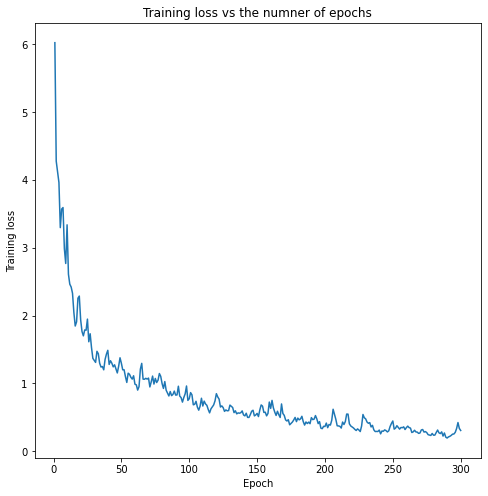

In [ ]:
# Training the network
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def convert_tensor(data, device):
  img, steering_angle = data
  img[0] = img[0].float().to(device)
  img[1] = img[1].float().to(device)
  img[2] = img[2].float().to(device)
  steering_angle = steering_angle.float().to(device)
  return img, steering_angle

epochs = 300
# 80% possibility of using ground 
train_loss = []
for epoch in range(epochs):  # loop over the dataset multiple times
    model.to(device)
    running_loss = 0.0
    model.train()
    # data in the trainloader consists of three tuples 
    for i, (center, left, right) in enumerate(train_generator):
      center, left, right = convert_tensor(center, device), convert_tensor(left, device), convert_tensor(right, device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # get the input; data is a list of [inputs, labels]
      datas = [center, left, right]
      for data in datas:
        img, steering_angle = data
        img1 = img[0].unsqueeze(1)
        img2 = img[1].unsqueeze(1)
        img3 = img[2].unsqueeze(1)
        img = torch.cat((img1,img2,img3),1)
        # forward + backward + optimize
        img = img.permute(0,1,4,2,3)
        num = random.uniform(0,1)
        if epochs < 30:
          output = torch.unsqueeze(steering_angle + 0.0001)
          if num < 0.9:
            output = torch.unsqueeze(steering_angle + 0.0001)
          else:
            output = model(img)
        else:
          output = model(img)
        loss = criterion(output, steering_angle.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
      
      if (i+1) % 5 == 0:    # print every 5 mini-batches
          print("Epoch: [{}/{}], loss: {}".format(epoch+1, epochs, running_loss / (i+1)))
    train_loss.append(running_loss)      

print('Finished Training!')
plt.figure(figsize=(8,8))
plt.plot(1+np.arange(len(train_loss)),train_loss)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.title('Training loss vs the numner of epochs')
plt.show()

In [ ]:
# Testing the network
model.eval()
test_loss = []

with torch.set_grad_enabled(False):
      for i, (center, left, right) in enumerate(test_generator):
        running_loss = 0
        center, left, right = convert_tensor(center, device), convert_tensor(left, device), convert_tensor(right, device)
        # zero the parameter gradients
        optimizer.zero_grad()    
        # get the input; data is a list of [inputs, labels]
        datas = [center, left, right]        
        for data in datas:
          img, steering_angle = data
          img1 = img[0].unsqueeze(1)
          img2 = img[1].unsqueeze(1)
          img3 = img[2].unsqueeze(1)
          img = torch.cat((img1,img2,img3),1)
          img = img.permute(0,1,4,2,3)
          output = model(img)
          loss = criterion(output, steering_angle.unsqueeze(1))
          running_loss += loss.data.item()
          test_loss.append(running_loss)

In [ ]:
print('Test Loss: %.3f '% (sum(test_loss)/(len(test_loss))))

Test Loss: 0.094 


In [ ]:
# Saving the model
state = {'model': model.module if device == 'cuda:0' else model,}
torch.save(state, 'model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>